In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torch torchvision timm --quiet

import os
import time
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00:00:0100:01


In [2]:
print("\n\033[1m[1/8] Initializing setup...\033[0m")
start_time = time.time()

config = {
    "paths": {
        "train": "/kaggle/input/pytorch-challange-flower-dataset/dataset/train",
        "valid": "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid",
        "test": "/kaggle/input/pytorch-challange-flower-dataset/dataset/test",
        "cat_to_name": "/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json",
        "submission": "submission.csv"
    },
    "training": {
        "batch_size": 32,
        "epochs": 35,
        "lr": 0.0001,
        "weight_decay": 0.0005,
        "grid_size": 3,
        "patience": 5,
        "dropout": 0.6
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_classes": 102,
    "seed": 42
}

torch.manual_seed(config["seed"])

with open(config['paths']['cat_to_name']) as f:
    cat_to_name = json.load(f)

print(f"Setup completed in {time.time()-start_time:.2f}s")
print(f"Using device: {config['device'].upper()}")



[1/8] Initializing setup...
Setup completed in 0.07s
Using device: CUDA


In [3]:
print("\n\033[1m[2/8] Preparing datasets with augmentations...\033[0m")
start_time = time.time()


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02)
    ], p=0.6),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(config['paths']['train'], transform=train_transforms)
valid_data = datasets.ImageFolder(config['paths']['valid'], transform=valid_transforms)

train_loader = DataLoader(train_data, batch_size=config['training']['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=config['training']['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

print(f"Datasets prepared in {time.time() - start_time:.2f}s")
print(f"Training samples: {len(train_data)} | Validation samples: {len(valid_data)}")


[2/8] Preparing datasets with augmentations...
Datasets prepared in 8.45s
Training samples: 6552 | Validation samples: 818


In [4]:
print("\n\033[1m[3/8] Building models with fine-tuning...\033[0m")
start_time = time.time()

class SharedClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.6):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

class GlobalFeatureModel(nn.Module):
    def __init__(self, classifier, dropout=0.6):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        # Modify last layer for feature output, remove fc
        self.backbone.fc = nn.Identity()
        self.classifier = classifier
    def forward(self, x):
        features = self.backbone(x)  # [B, 2048]
        out = self.classifier(features)
        return out

class GridFeatureModel(nn.Module):
    def __init__(self, grid_size=3, classifier=None, dropout=0.6):
        super().__init__()
        self.grid_size = grid_size
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.feature_dim = 2048 * (grid_size ** 2)
        self.classifier = classifier
    def split_grids(self, x):
        B, C, H, W = x.shape
        gh, gw = H // self.grid_size, W // self.grid_size
        grids = x.unfold(2, gh, gh).unfold(3, gw, gw)
        grids = grids.contiguous().view(B, C, self.grid_size ** 2, gh, gw)
        grids = grids.permute(0, 2, 1, 3, 4).reshape(-1, C, gh, gw)
        return grids
    def forward(self, x):
        grids = self.split_grids(x)
        features = self.backbone(grids)  # [B*grid*grid, 2048]
        features = features.view(x.size(0), -1)  # [B, 2048*grid^2]
        out = self.classifier(features)
        return out


shared_classifier_global = SharedClassifier(input_dim=2048, num_classes=config['num_classes'], dropout=config['training']['dropout']).to(config['device'])
shared_classifier_grid = SharedClassifier(input_dim=2048 * (config['training']['grid_size'] ** 2), num_classes=config['num_classes'], dropout=config['training']['dropout']).to(config['device'])


global_model = GlobalFeatureModel(shared_classifier_global).to(config['device'])
grid_model = GridFeatureModel(grid_size=config['training']['grid_size'], classifier=shared_classifier_grid).to(config['device'])

print(f"Models built in {time.time()-start_time:.2f}s")
print(f"Global model params: {sum(p.numel() for p in global_model.parameters())}")
print(f"Grid model params: {sum(p.numel() for p in grid_model.parameters())}")


global_optimizer = optim.Adam(global_model.parameters(), lr=config['training']['lr'], weight_decay=config['training']['weight_decay'])
grid_optimizer = optim.Adam(grid_model.parameters(), lr=config['training']['lr'], weight_decay=config['training']['weight_decay'])

criterion = nn.CrossEntropyLoss()

global_scheduler = optim.lr_scheduler.ReduceLROnPlateau(global_optimizer, mode='max', factor=0.5, patience=3, verbose=True)
grid_scheduler = optim.lr_scheduler.ReduceLROnPlateau(grid_optimizer, mode='max', factor=0.5, patience=3, verbose=True)


[3/8] Building models with fine-tuning...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


Models built in 2.52s
Global model params: 32326822
Grid model params: 99435686


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    losses = 0.0
    with torch.no_grad(), tqdm(dataloader, desc="Validating") as pbar:
        for images, labels in pbar:
            images = images.to(config['device'], non_blocking=True)
            labels = labels.to(config['device'], non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix(loss=losses / total, acc=100. * correct / total)
    acc = 100. * correct / total
    avg_loss = losses / len(dataloader)
    return acc, avg_loss

def train(model, optimizer, scheduler, dataloaders, epochs, model_name="Model"):
    best_acc = 0.0
    patience_counter = 0
    scaler = torch.cuda.amp.GradScaler(enabled=(config['device']=='cuda'))

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(dataloaders['train'], desc=f"{model_name} Epoch {epoch}") as pbar:
            for inputs, labels in pbar:
                inputs = inputs.to(config['device'], non_blocking=True)
                labels = labels.to(config['device'], non_blocking=True)

                optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=(config['device']=='cuda')):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
                scaler.step(optimizer)
                scaler.update()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

        val_acc, val_loss = validate(model, dataloaders['valid'])
        scheduler.step(val_acc)

        print(f"\n{model_name} Epoch {epoch} Summary:")
        print(f"Train Loss: {running_loss/len(dataloaders['train']):.4f} | Train Acc: {100.*correct/total:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            
            torch.save(model.state_dict(), f"best_{model_name.replace(' ', '_').lower()}.pth")
        else:
            patience_counter += 1
            if patience_counter >= config['training']['patience']:
                print(f"Early stopping triggered at epoch {epoch}")
                break
  
    model.load_state_dict(torch.load(f"best_{model_name.replace(' ', '_').lower()}.pth"))
    return best_acc


print("\n\033[1m[6/8] Training Global Feature Model...\033[0m")
global_best_acc = train(global_model, global_optimizer, global_scheduler,
                        {'train': train_loader, 'valid': valid_loader},
                        config['training']['epochs'],
                        model_name="Global Feature Model")

print("\n\033[1m[7/8] Training Grid Feature Model with Fine-tuning...\033[0m")
grid_best_acc = train(grid_model, grid_optimizer, grid_scheduler,
                     {'train': train_loader, 'valid': valid_loader},
                     config['training']['epochs'],
                     model_name="Grid Feature Model")

/tmp/ipykernel_35/3516369820.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(config['device']=='cuda'))



[6/8] Training Global Feature Model...


Global Feature Model Epoch 1:   0%|          | 0/205 [00:00<?, ?it/s]/tmp/ipykernel_35/3516369820.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config['device']=='cuda')):
Validating: 100%|██████████| 26/26 [00:04<00:00,  5.70it/s, acc=95.1, loss=0.00793]



Global Feature Model Epoch 1 Summary:
Train Loss: 1.3555 | Train Acc: 71.38% | Val Loss: 0.2495 | Val Acc: 95.11%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.98it/s, acc=95.7, loss=0.00627]



Global Feature Model Epoch 2 Summary:
Train Loss: 0.2421 | Train Acc: 94.41% | Val Loss: 0.1973 | Val Acc: 95.72%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.78it/s, acc=95.5, loss=0.00524]



Global Feature Model Epoch 3 Summary:
Train Loss: 0.1678 | Train Acc: 95.92% | Val Loss: 0.1649 | Val Acc: 95.48%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.58it/s, acc=94.6, loss=0.00646]



Global Feature Model Epoch 4 Summary:
Train Loss: 0.1310 | Train Acc: 96.73% | Val Loss: 0.2031 | Val Acc: 94.62%


Validating: 100%|██████████| 26/26 [00:03<00:00,  8.02it/s, acc=95, loss=0.00654]  



Global Feature Model Epoch 5 Summary:
Train Loss: 0.1115 | Train Acc: 97.01% | Val Loss: 0.2059 | Val Acc: 94.99%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.63it/s, acc=96.2, loss=0.00498]



Global Feature Model Epoch 6 Summary:
Train Loss: 0.0952 | Train Acc: 97.41% | Val Loss: 0.1568 | Val Acc: 96.21%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.34it/s, acc=96.5, loss=0.00486]



Global Feature Model Epoch 7 Summary:
Train Loss: 0.0962 | Train Acc: 97.30% | Val Loss: 0.1528 | Val Acc: 96.45%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.67it/s, acc=95.1, loss=0.00603]



Global Feature Model Epoch 8 Summary:
Train Loss: 0.0902 | Train Acc: 97.54% | Val Loss: 0.1896 | Val Acc: 95.11%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.70it/s, acc=96.7, loss=0.00408]



Global Feature Model Epoch 9 Summary:
Train Loss: 0.0930 | Train Acc: 97.66% | Val Loss: 0.1284 | Val Acc: 96.70%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, acc=97.1, loss=0.0046] 



Global Feature Model Epoch 10 Summary:
Train Loss: 0.0875 | Train Acc: 97.74% | Val Loss: 0.1447 | Val Acc: 97.07%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.79it/s, acc=94.3, loss=0.00793]



Global Feature Model Epoch 11 Summary:
Train Loss: 0.0772 | Train Acc: 97.92% | Val Loss: 0.2495 | Val Acc: 94.25%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s, acc=96.8, loss=0.00539]



Global Feature Model Epoch 12 Summary:
Train Loss: 0.0833 | Train Acc: 97.95% | Val Loss: 0.1695 | Val Acc: 96.82%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.49it/s, acc=95.6, loss=0.0051] 



Global Feature Model Epoch 13 Summary:
Train Loss: 0.0702 | Train Acc: 98.23% | Val Loss: 0.1604 | Val Acc: 95.60%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.57it/s, acc=96.6, loss=0.00479]



Global Feature Model Epoch 14 Summary:
Train Loss: 0.0665 | Train Acc: 98.31% | Val Loss: 0.1506 | Val Acc: 96.58%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, acc=97.3, loss=0.00366]



Global Feature Model Epoch 15 Summary:
Train Loss: 0.0308 | Train Acc: 99.28% | Val Loss: 0.1150 | Val Acc: 97.31%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.59it/s, acc=98.5, loss=0.00253]



Global Feature Model Epoch 16 Summary:
Train Loss: 0.0169 | Train Acc: 99.66% | Val Loss: 0.0797 | Val Acc: 98.53%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.25it/s, acc=98, loss=0.00249]  



Global Feature Model Epoch 17 Summary:
Train Loss: 0.0121 | Train Acc: 99.74% | Val Loss: 0.0783 | Val Acc: 98.04%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.56it/s, acc=98.5, loss=0.0027]  



Global Feature Model Epoch 18 Summary:
Train Loss: 0.0154 | Train Acc: 99.59% | Val Loss: 0.0848 | Val Acc: 98.53%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.91it/s, acc=98.2, loss=0.0024]  



Global Feature Model Epoch 19 Summary:
Train Loss: 0.0146 | Train Acc: 99.66% | Val Loss: 0.0756 | Val Acc: 98.17%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.68it/s, acc=98.2, loss=0.00287]



Global Feature Model Epoch 20 Summary:
Train Loss: 0.0166 | Train Acc: 99.59% | Val Loss: 0.0904 | Val Acc: 98.17%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.80it/s, acc=98.3, loss=0.00248]



Global Feature Model Epoch 21 Summary:
Train Loss: 0.0080 | Train Acc: 99.83% | Val Loss: 0.0781 | Val Acc: 98.29%
Early stopping triggered at epoch 21

[7/8] Training Grid Feature Model with Fine-tuning...


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s, acc=91.4, loss=0.0119] 



Grid Feature Model Epoch 1 Summary:
Train Loss: 1.5002 | Train Acc: 66.38% | Val Loss: 0.3748 | Val Acc: 91.44%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.37it/s, acc=92.8, loss=0.0084] 



Grid Feature Model Epoch 2 Summary:
Train Loss: 0.3802 | Train Acc: 91.16% | Val Loss: 0.2642 | Val Acc: 92.79%


Validating: 100%|██████████| 26/26 [00:04<00:00,  6.46it/s, acc=95.2, loss=0.00636]



Grid Feature Model Epoch 3 Summary:
Train Loss: 0.2417 | Train Acc: 94.26% | Val Loss: 0.2002 | Val Acc: 95.23%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.56it/s, acc=95.4, loss=0.00574]



Grid Feature Model Epoch 4 Summary:
Train Loss: 0.1808 | Train Acc: 95.85% | Val Loss: 0.1806 | Val Acc: 95.35%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.14it/s, acc=93.9, loss=0.00674]



Grid Feature Model Epoch 5 Summary:
Train Loss: 0.1576 | Train Acc: 95.96% | Val Loss: 0.2121 | Val Acc: 93.89%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s, acc=94.5, loss=0.00719]



Grid Feature Model Epoch 6 Summary:
Train Loss: 0.1399 | Train Acc: 96.40% | Val Loss: 0.2262 | Val Acc: 94.50%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.88it/s, acc=95.6, loss=0.00578]



Grid Feature Model Epoch 7 Summary:
Train Loss: 0.1236 | Train Acc: 96.89% | Val Loss: 0.1818 | Val Acc: 95.60%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s, acc=95, loss=0.00609]  



Grid Feature Model Epoch 8 Summary:
Train Loss: 0.1171 | Train Acc: 97.07% | Val Loss: 0.1917 | Val Acc: 94.99%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, acc=95.6, loss=0.00537]



Grid Feature Model Epoch 9 Summary:
Train Loss: 0.1080 | Train Acc: 97.33% | Val Loss: 0.1689 | Val Acc: 95.60%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s, acc=96.2, loss=0.00547]



Grid Feature Model Epoch 10 Summary:
Train Loss: 0.1034 | Train Acc: 97.50% | Val Loss: 0.1721 | Val Acc: 96.21%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s, acc=95.6, loss=0.00524]



Grid Feature Model Epoch 11 Summary:
Train Loss: 0.1006 | Train Acc: 97.45% | Val Loss: 0.1648 | Val Acc: 95.60%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s, acc=93.9, loss=0.00672]



Grid Feature Model Epoch 12 Summary:
Train Loss: 0.0886 | Train Acc: 97.94% | Val Loss: 0.2114 | Val Acc: 93.89%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.61it/s, acc=95.4, loss=0.00561]



Grid Feature Model Epoch 13 Summary:
Train Loss: 0.0905 | Train Acc: 97.73% | Val Loss: 0.1766 | Val Acc: 95.35%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s, acc=94.3, loss=0.00716]



Grid Feature Model Epoch 14 Summary:
Train Loss: 0.0904 | Train Acc: 97.92% | Val Loss: 0.2253 | Val Acc: 94.25%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.73it/s, acc=96.8, loss=0.004]  



Grid Feature Model Epoch 15 Summary:
Train Loss: 0.0362 | Train Acc: 99.51% | Val Loss: 0.1257 | Val Acc: 96.82%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.55it/s, acc=98.3, loss=0.00282]



Grid Feature Model Epoch 16 Summary:
Train Loss: 0.0289 | Train Acc: 99.30% | Val Loss: 0.0887 | Val Acc: 98.29%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s, acc=98.2, loss=0.00283]



Grid Feature Model Epoch 17 Summary:
Train Loss: 0.0247 | Train Acc: 99.50% | Val Loss: 0.0889 | Val Acc: 98.17%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, acc=97.8, loss=0.00314]



Grid Feature Model Epoch 18 Summary:
Train Loss: 0.0180 | Train Acc: 99.73% | Val Loss: 0.0988 | Val Acc: 97.80%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, acc=97.3, loss=0.0033] 



Grid Feature Model Epoch 19 Summary:
Train Loss: 0.0214 | Train Acc: 99.59% | Val Loss: 0.1037 | Val Acc: 97.31%


Validating: 100%|██████████| 26/26 [00:03<00:00,  6.90it/s, acc=97.6, loss=0.00363]



Grid Feature Model Epoch 20 Summary:
Train Loss: 0.0198 | Train Acc: 99.63% | Val Loss: 0.1142 | Val Acc: 97.56%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s, acc=98.4, loss=0.00263]



Grid Feature Model Epoch 21 Summary:
Train Loss: 0.0136 | Train Acc: 99.80% | Val Loss: 0.0827 | Val Acc: 98.41%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.17it/s, acc=98.4, loss=0.00268]



Grid Feature Model Epoch 22 Summary:
Train Loss: 0.0088 | Train Acc: 99.88% | Val Loss: 0.0842 | Val Acc: 98.41%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.56it/s, acc=98.7, loss=0.00255]



Grid Feature Model Epoch 23 Summary:
Train Loss: 0.0078 | Train Acc: 99.91% | Val Loss: 0.0802 | Val Acc: 98.66%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.47it/s, acc=98.4, loss=0.00257]



Grid Feature Model Epoch 24 Summary:
Train Loss: 0.0078 | Train Acc: 99.89% | Val Loss: 0.0810 | Val Acc: 98.41%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.10it/s, acc=98.3, loss=0.00258]



Grid Feature Model Epoch 25 Summary:
Train Loss: 0.0061 | Train Acc: 99.94% | Val Loss: 0.0812 | Val Acc: 98.29%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s, acc=98.3, loss=0.00244]



Grid Feature Model Epoch 26 Summary:
Train Loss: 0.0083 | Train Acc: 99.91% | Val Loss: 0.0767 | Val Acc: 98.29%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s, acc=98.4, loss=0.00261]



Grid Feature Model Epoch 27 Summary:
Train Loss: 0.0095 | Train Acc: 99.82% | Val Loss: 0.0821 | Val Acc: 98.41%


Validating: 100%|██████████| 26/26 [00:03<00:00,  7.31it/s, acc=98.5, loss=0.00244]



Grid Feature Model Epoch 28 Summary:
Train Loss: 0.0057 | Train Acc: 99.95% | Val Loss: 0.0766 | Val Acc: 98.53%
Early stopping triggered at epoch 28


In [6]:
print("\n\033[1m[8/8] Training completed!\033[0m")
print(f"Best Validation Accuracy - Global Feature Model : {global_best_acc:.2f}%")
print(f"Best Validation Accuracy - Grid Feature Model   : {grid_best_acc:.2f}%")

if grid_best_acc > global_best_acc + 2.0:
    print(f"\n Grid-based feature extraction outperformed global features by {grid_best_acc - global_best_acc:.2f}% !")
else:
    diff = global_best_acc - grid_best_acc
    print(f"\n Grid-based did not outperform global features by desired margin.")
    if diff > 0:
        print(f"Global features are better by {diff:.2f}%. Try tuning hyperparameters or augmentations more.")


[8/8] Training completed!
Best Validation Accuracy - Global Feature Model : 98.53%
Best Validation Accuracy - Grid Feature Model   : 98.66%

 Grid-based did not outperform global features by desired margin.



[9/9] Generating comparative visualizations...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


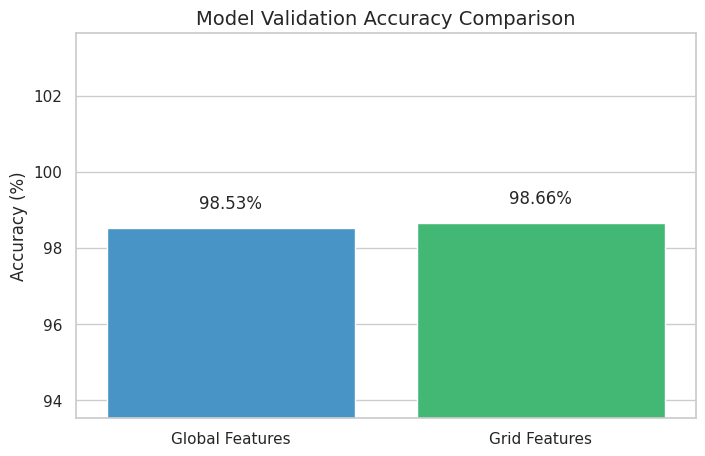

In [7]:
print("\n\033[1m[9/9] Generating comparative visualizations...\033[0m")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted')


plt.figure(figsize=(8, 5))
models = ['Global Features', 'Grid Features']
accuracies = [global_best_acc, grid_best_acc]

ax = sns.barplot(x=models, y=accuracies, palette=['#3498db', '#2ecc71'])
plt.title("Model Validation Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(min(accuracies)-5, max(accuracies)+5)

for i, v in enumerate(accuracies):
    ax.text(i, v+0.5, f"{v:.2f}%", ha='center', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.show()


Global Model Confusion Matrix:


Generating Global Features predictions: 100%|██████████| 26/26 [00:03<00:00,  7.70it/s]


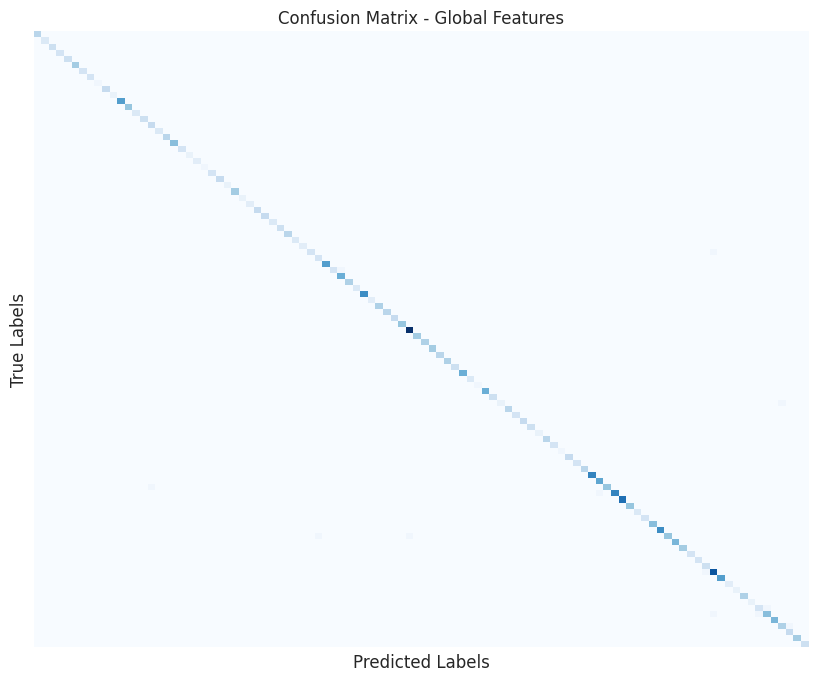


Grid Model Confusion Matrix:


Generating Grid Features predictions: 100%|██████████| 26/26 [00:03<00:00,  7.60it/s]


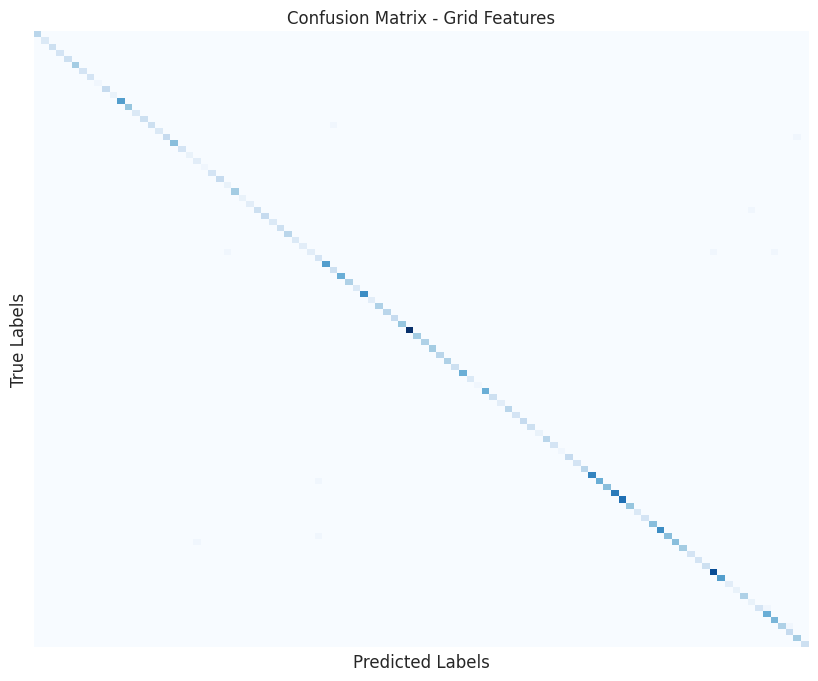

In [8]:
def generate_confusion_matrix(model, dataloader, title):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Generating {title} predictions"):
            inputs = inputs.to(config['device'])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap='Blues', cbar=False, 
               xticklabels=False, yticklabels=False)
    plt.title(f"Confusion Matrix - {title}", fontsize=12)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

print("\n\033[1mGlobal Model Confusion Matrix:\033[0m")
generate_confusion_matrix(global_model, valid_loader, "Global Features")

print("\n\033[1mGrid Model Confusion Matrix:\033[0m")
generate_confusion_matrix(grid_model, valid_loader, "Grid Features")


Global Feature Space:


Extracting features for Global Model: 100%|██████████| 26/26 [00:03<00:00,  7.59it/s]


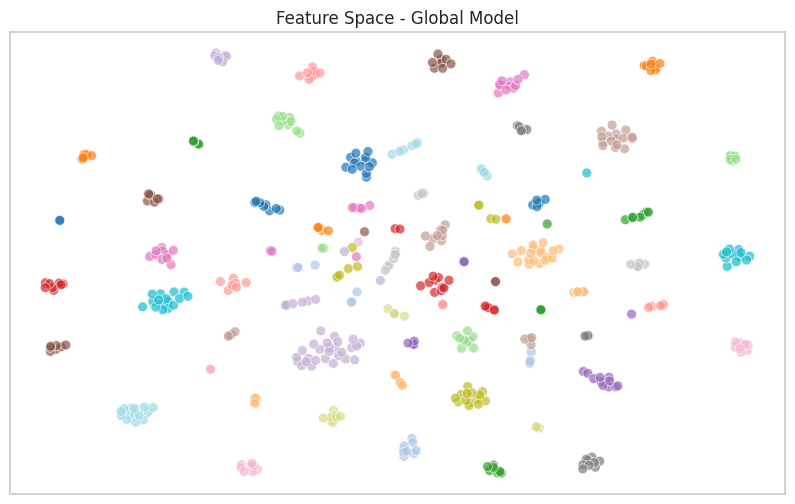


Grid Feature Space:


Extracting features for Grid Model: 100%|██████████| 26/26 [00:03<00:00,  7.95it/s]


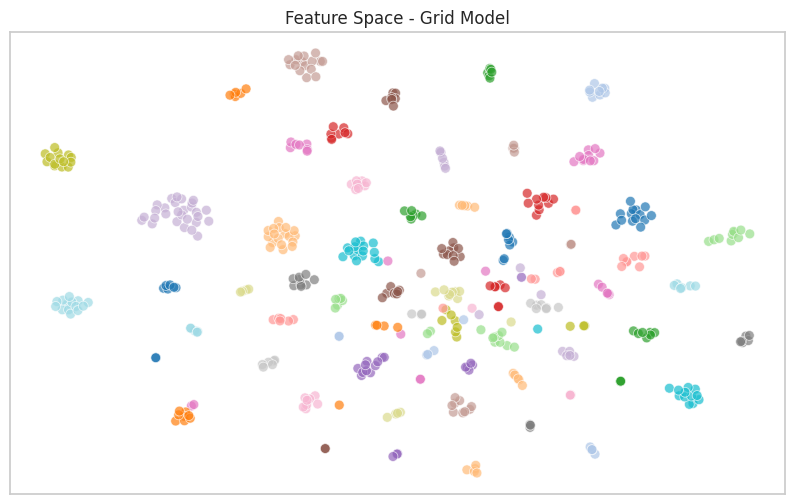

In [9]:
def plot_feature_space(model, dataloader, title):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, lbls in tqdm(dataloader, desc=f"Extracting features for {title}"):
            inputs = inputs.to(config['device'])
            feats = model.backbone(inputs).cpu().numpy()
            features.append(feats)
            labels.extend(lbls.numpy())
    
    features = np.concatenate(features)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(features[:500])  # Use subset for speed
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=np.array(labels)[:500], 
                    palette="tab20", alpha=0.7, s=50, legend=False)
    plt.title(f"Feature Space - {title}", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.show()

print("\n\033[1mGlobal Feature Space:\033[0m")
plot_feature_space(global_model, valid_loader, "Global Model")

print("\n\033[1mGrid Feature Space:\033[0m")
plot_feature_space(grid_model, valid_loader, "Grid Model")


Sample Validation Predictions:


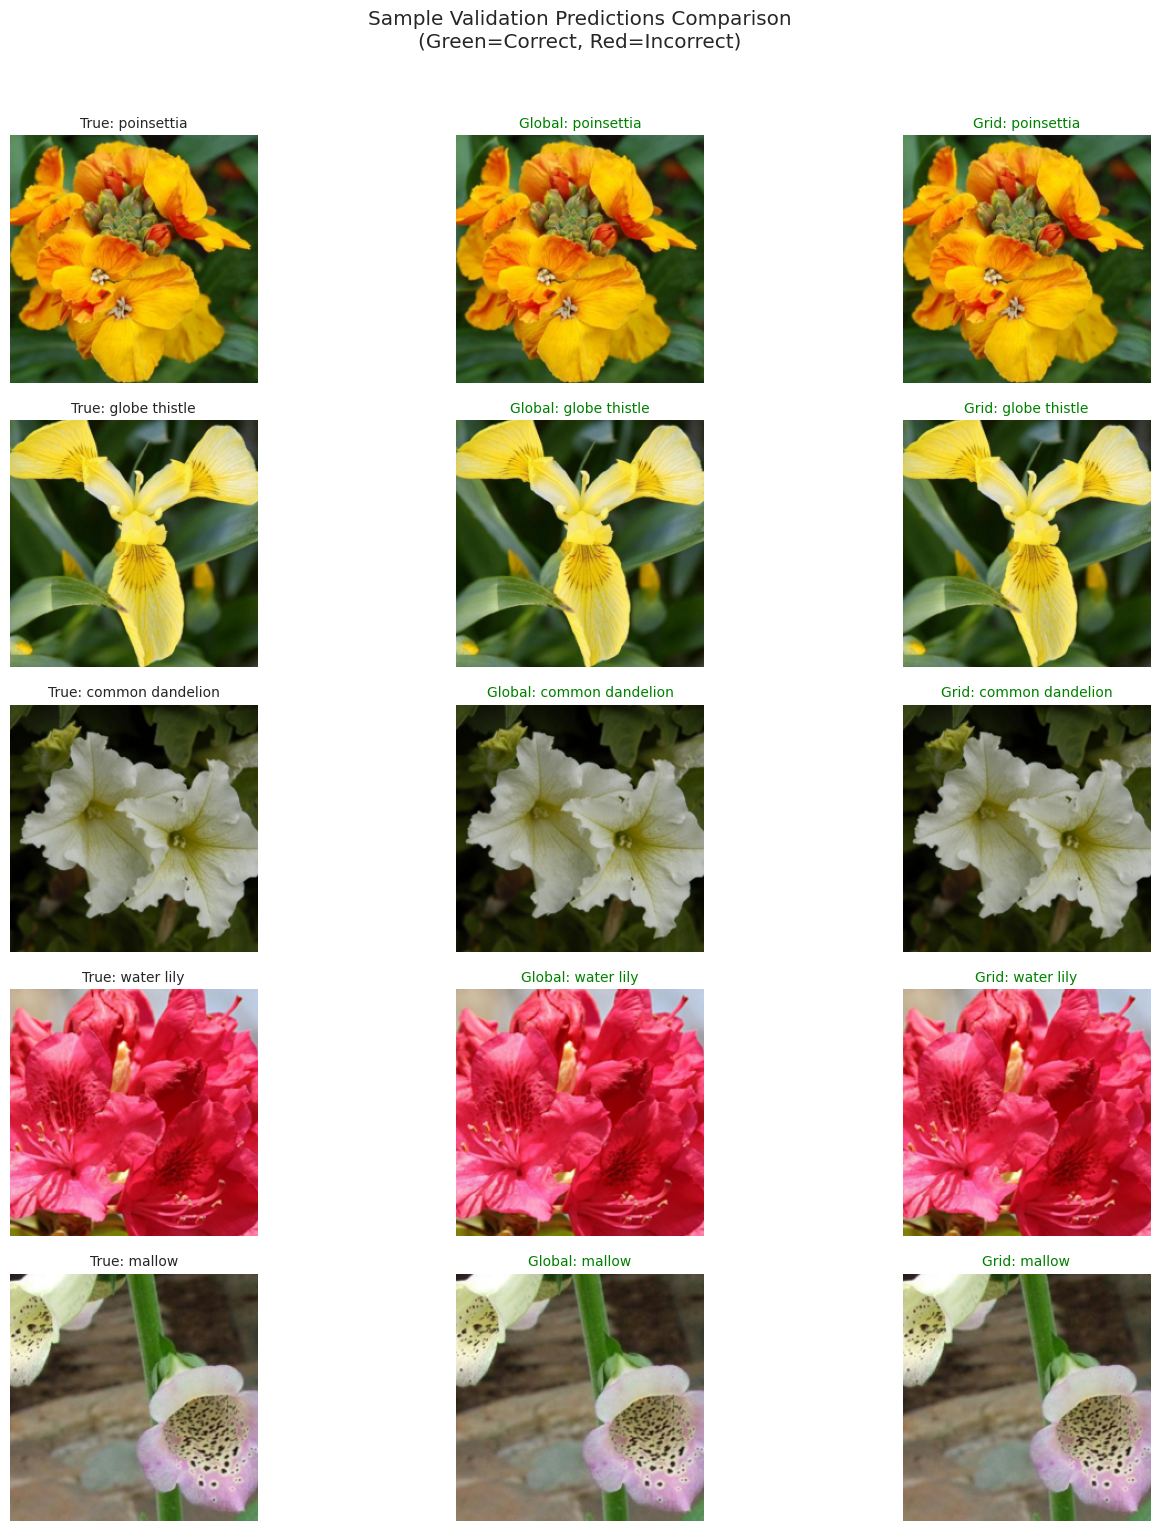

In [10]:
def unnormalize(tensor):
    """Convert normalized tensor to PIL image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    tensor = tensor * std + mean
    return transforms.ToPILImage()(tensor.cpu())

def show_predictions(num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*3))
    
    for idx in range(num_samples):
        # Get random validation sample
        img, label = valid_data[np.random.randint(len(valid_data))]
        img_tensor = img.unsqueeze(0).to(config['device'])
        
        # Get predictions
        with torch.no_grad():
            global_pred = torch.argmax(global_model(img_tensor)).item()
            grid_pred = torch.argmax(grid_model(img_tensor)).item()
        
        # Convert to names
        true_name = cat_to_name.get(str(label+1), "Unknown")
        global_name = cat_to_name.get(str(global_pred+1), "Unknown")
        grid_name = cat_to_name.get(str(grid_pred+1), "Unknown")
        
        # Plot
        axes[idx,0].imshow(unnormalize(img))
        axes[idx,0].set_title(f"True: {true_name}", fontsize=10)
        axes[idx,0].axis('off')
        
        axes[idx,1].imshow(unnormalize(img))
        axes[idx,1].set_title(f"Global: {global_name}", 
                            color='green' if global_pred == label else 'red', 
                            fontsize=10)
        axes[idx,1].axis('off')
        
        axes[idx,2].imshow(unnormalize(img))
        axes[idx,2].set_title(f"Grid: {grid_name}", 
                            color='green' if grid_pred == label else 'red', 
                            fontsize=10)
        axes[idx,2].axis('off')
    
    plt.suptitle("Sample Validation Predictions Comparison\n(Green=Correct, Red=Incorrect)", y=1.02)
    plt.tight_layout()
    plt.show()

print("\n\033[1mSample Validation Predictions:\033[0m")
show_predictions(5)

Calculating class accuracies: 100%|██████████| 26/26 [00:03<00:00,  7.44it/s]


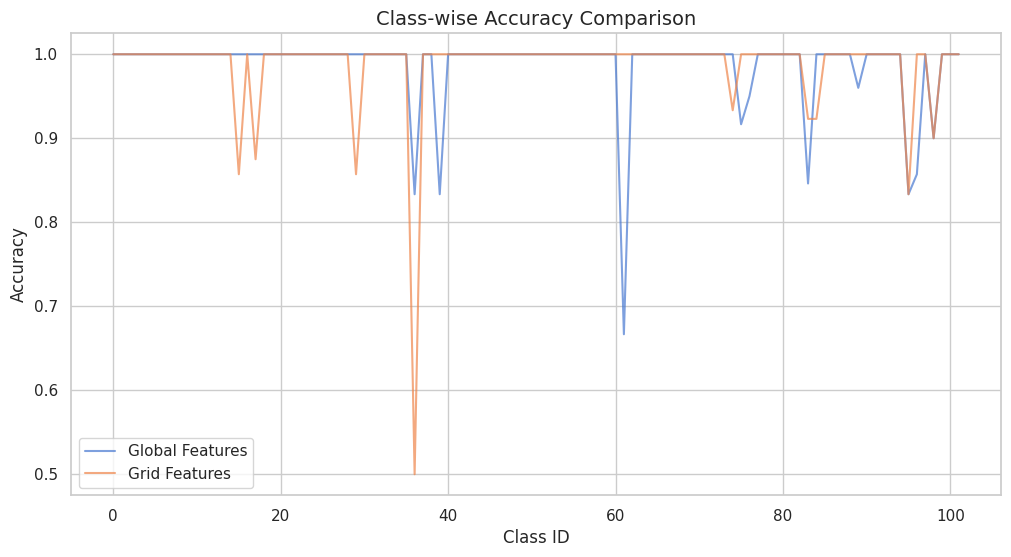

In [11]:
def calculate_class_accuracies(model, dataloader):
    model.eval()
    class_correct = np.zeros(config['num_classes'])
    class_total = np.zeros(config['num_classes'])
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Calculating class accuracies"):
            inputs = inputs.to(config['device'])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for lbl, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_correct[lbl] += (pred == lbl)
                class_total[lbl] += 1
                
    return class_correct / class_total

global_class_acc = calculate_class_accuracies(global_model, valid_loader)
grid_class_acc = calculate_class_accuracies(grid_model, valid_loader)

plt.figure(figsize=(12,6))
plt.plot(global_class_acc, label='Global Features', alpha=0.7)
plt.plot(grid_class_acc, label='Grid Features', alpha=0.7)
plt.title("Class-wise Accuracy Comparison", fontsize=14)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Test Image Predictions:


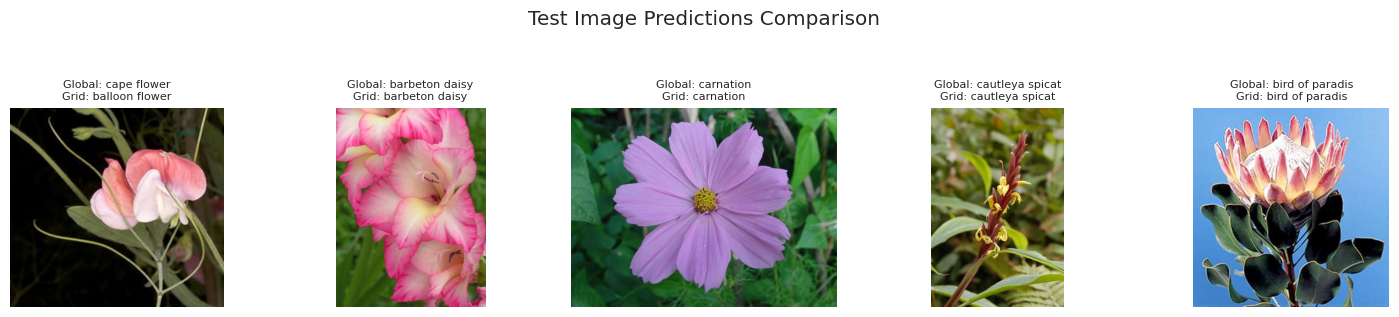


All visualizations generated!


In [13]:
from pathlib import Path

def predict_test_images(num_samples=5):
    test_dir = Path(config['paths']['test'])
    test_images = list(test_dir.glob('*.jpg'))
    
    if not test_images:
        print("\n No test images found!")
        return
    
    selected = np.random.choice(test_images, min(num_samples, len(test_images)), False)
    
    fig, axes = plt.subplots(1, len(selected), figsize=(15, 3))
    if len(selected) == 1:  # Handle single image case
        axes = [axes]
    
    for ax, img_path in zip(axes, selected):
        img = Image.open(img_path).convert('RGB')
        img_tensor = valid_transforms(img).unsqueeze(0).to(config['device'])
        
        with torch.no_grad():
            global_pred = torch.argmax(global_model(img_tensor)).item()
            grid_pred = torch.argmax(grid_model(img_tensor)).item()
        
        global_name = cat_to_name.get(str(global_pred+1), "Unknown")
        grid_name = cat_to_name.get(str(grid_pred+1), "Unknown")
        
        ax.imshow(img)
        ax.set_title(f"Global: {global_name[:15]}\nGrid: {grid_name[:15]}", fontsize=8)
        ax.axis('off')
    
    plt.suptitle("Test Image Predictions Comparison", y=1.05)
    plt.tight_layout()
    plt.show()

print("\n\033[1mTest Image Predictions:\033[0m")
predict_test_images(5)

print("\n\033[1mAll visualizations generated!\033[0m")
